In [14]:
import yfinance as yf
import statsmodels.api as sm
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import pacf
warnings.filterwarnings("ignore")
resample_map = {
    "weekly": "W",
    "biweekly": "2W",
    "monthly": "M"
}

# params
stock_list = ["2330.TW","2317.TW","1234.TW", "1315.TW"]
train_end = pd.to_datetime("2020-01-01")
train_start = train_end - timedelta(days=365)

df = yf.download(stock_list, start=train_start, end="2024-01-01", progress=False)
close = df['Adj Close']
pct_change = close.pct_change().dropna()
pct_change = pct_change.resample(resample_map['monthly']).sum()

In [15]:

starter_index = np.where(pct_change.index < train_end)[0][-1]
factors = []
indices = []
for index in range(len(pct_change)-starter_index+1):

    # rolling calculating time series
    pct_change_train = pct_change.iloc[index:starter_index+index]
    print(pct_change_train.index[0], pct_change_train.index[-1])
    prediction_factor = []
    for ticker in stock_list:

        # get max lags with pacf
        pacf_values = pacf(pct_change_train[ticker], method='ywm')
        
        N = len(pct_change_train[ticker])
        threshold = 1.96 / np.sqrt(N)

        significant_indices = np.where(np.abs(pacf_values) > threshold)[0]
        significant_pacf_values = pacf_values[significant_indices]
        if len(significant_indices) >= 2:
            best_lag_n = significant_indices[1]
        elif len(significant_indices) == 1:
            best_lag_n = np.argmax(np.abs(pacf_values[1:])) + 1

        # get predictions(upward/downward)
        train_data = pct_change_train[ticker]
        model = sm.tsa.arima.ARIMA(train_data, order=(best_lag_n, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
        model_fit = model.fit()
        prediction = model_fit.forecast()
        # print(ticker, prediction[0], prediction.index[0])
        prediction_factor.append(prediction[0])
    factors.append(prediction_factor)
    indices.append(pct_change_train.index[-1])

2019-01-31 00:00:00 2019-11-30 00:00:00
2019-02-28 00:00:00 2019-12-31 00:00:00


2019-03-31 00:00:00 2020-01-31 00:00:00
2019-04-30 00:00:00 2020-02-29 00:00:00
2019-05-31 00:00:00 2020-03-31 00:00:00
2019-06-30 00:00:00 2020-04-30 00:00:00
2019-07-31 00:00:00 2020-05-31 00:00:00
2019-08-31 00:00:00 2020-06-30 00:00:00
2019-09-30 00:00:00 2020-07-31 00:00:00
2019-10-31 00:00:00 2020-08-31 00:00:00
2019-11-30 00:00:00 2020-09-30 00:00:00
2019-12-31 00:00:00 2020-10-31 00:00:00
2020-01-31 00:00:00 2020-11-30 00:00:00
2020-02-29 00:00:00 2020-12-31 00:00:00
2020-03-31 00:00:00 2021-01-31 00:00:00
2020-04-30 00:00:00 2021-02-28 00:00:00
2020-05-31 00:00:00 2021-03-31 00:00:00
2020-06-30 00:00:00 2021-04-30 00:00:00
2020-07-31 00:00:00 2021-05-31 00:00:00
2020-08-31 00:00:00 2021-06-30 00:00:00
2020-09-30 00:00:00 2021-07-31 00:00:00
2020-10-31 00:00:00 2021-08-31 00:00:00
2020-11-30 00:00:00 2021-09-30 00:00:00
2020-12-31 00:00:00 2021-10-31 00:00:00
2021-01-31 00:00:00 2021-11-30 00:00:00
2021-02-28 00:00:00 2021-12-31 00:00:00
2021-03-31 00:00:00 2022-01-31 00:00:00


In [16]:
tester = pd.DataFrame(factors, columns=stock_list, index=indices)
df1 = tester.dropna(axis='columns', how='all').copy()
demean = df1.sub(df1.mean(axis=1), axis=0)
weighting = demean.div(demean.abs().sum(axis=1), axis=0)

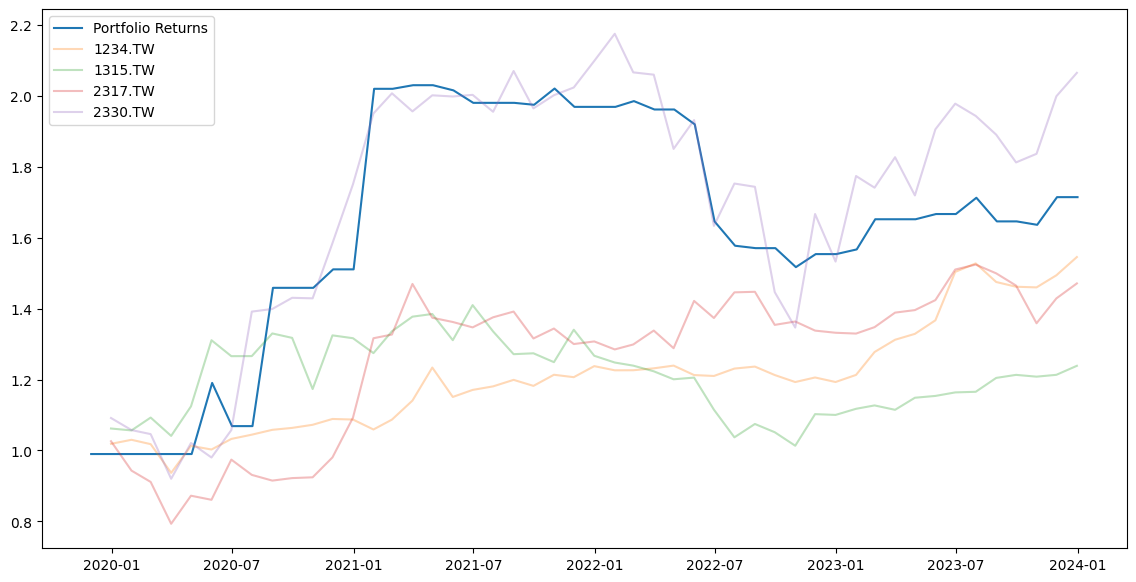

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data
close_prices_df = pd.DataFrame(df['Open'], index=[i + timedelta(days=1) for i in tester.index]).dropna()
# Normalize portfolio weights
def normalize_weights(df):
    long_weights = df[df > 0]
    
    normalized_long_weights = long_weights.div(long_weights.sum(axis=1), axis=0).fillna(0)
    
    return normalized_long_weights

normalized_long_weights = normalize_weights(weighting)
normalized_long_weights.index = [i + timedelta(1) for i in normalized_long_weights.index]
portfolio_returns = (normalized_long_weights * close_prices_df.pct_change()).sum(axis=1)
# Plot returns
plt.figure(figsize=(14, 7))
plt.plot((1 + portfolio_returns).cumprod()*0.99, label='Portfolio Returns')

benchmark = pct_change[pct_change.index >= portfolio_returns.index[0]]
plt.plot((1+ benchmark).cumprod(), label=list(benchmark.columns), alpha=0.3)
plt.legend()
plt.show()

# Calculate performance metrics
def sharpe_ratio(returns, risk_free_rate=0.03):
    excess_returns = returns - risk_free_rate
    print(np.std(excess_returns))
    return  np.mean(portfolio_returns)/ np.std(excess_returns)

In [18]:
for index, row in normalized_long_weights.iterrows():
    print(row[row > 0].index.sort_values())

Index(['1315.TW'], dtype='object')
Index(['1315.TW'], dtype='object')
Index(['2317.TW', '2330.TW'], dtype='object')
Index(['1315.TW', '2317.TW', '2330.TW'], dtype='object')
Index(['1315.TW'], dtype='object')
Index(['1315.TW'], dtype='object')
Index(['1315.TW', '2317.TW'], dtype='object')
Index(['1315.TW', '2330.TW'], dtype='object')
Index(['1315.TW'], dtype='object')
Index(['2330.TW'], dtype='object')
Index(['1315.TW'], dtype='object')
Index(['1234.TW', '1315.TW', '2317.TW'], dtype='object')
Index(['1315.TW', '2330.TW'], dtype='object')
Index(['2330.TW'], dtype='object')
Index(['2317.TW', '2330.TW'], dtype='object')
Index(['2317.TW', '2330.TW'], dtype='object')
Index(['2330.TW'], dtype='object')
Index(['1234.TW', '2330.TW'], dtype='object')
Index(['1315.TW', '2330.TW'], dtype='object')
Index(['2317.TW'], dtype='object')
Index(['1234.TW', '2317.TW'], dtype='object')
Index(['1315.TW', '2317.TW', '2330.TW'], dtype='object')
Index(['1234.TW', '1315.TW'], dtype='object')
Index(['1234.TW', '